In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import glob
from scipy.interpolate import interp1d

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Use cell to pull/push to Github
%cd drive/MyDrive
!git clone https://github.com/commaai/calib_challenge.git
%cd calib_challenge

/content/drive/MyDrive
fatal: destination path 'calib_challenge' already exists and is not an empty directory.
/content/drive/MyDrive/calib_challenge


In [3]:
# Load video and initialize parameters
focal_length = 910  # Provided focal length
roi_width = 300  # Adjust based on video resolution
roi_height = 200

In [4]:
# Allow customization through function arguments
def estimate_direction(frame, prev_frame, roi_width=300, roi_height=200):
    # Preprocess frame
    # gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # gray = cv2.GaussianBlur(gray, (5, 5), 0)  # Optional smoothing

    # Define region of interest (adjust based on vehicle position)
    roi = (frame.shape[1] // 2 - roi_width // 2, frame.shape[0] // 2 - roi_height // 2, roi_width, roi_height)

    # Calculate optical flow
    flow = cv2.calcOpticalFlowFarneback(
        prev=prev_frame,
        next=frame,
        flow=None,
        pyr_scale=0.5,
        levels=5,
        winsize=13,
        iterations=10,
        poly_n=5,
        poly_sigma=1.1,
        flags=0
    )

    # Extract average motion vector within ROI
    roi_flow = flow[roi[1]:roi[1]+roi_height, roi[0]:roi[0]+roi_width]
    avg_flow = np.mean(roi_flow, axis=(0, 1))

    # Convert flow to pitch and yaw angles
    pitch = np.arctan2(avg_flow[1], focal_length)
    yaw = np.arctan2(avg_flow[0], focal_length)

    return pitch, yaw, flow

In [5]:
def draw_flow(frame, flow, step=16):
    h, w = frame.shape[:2]
    y, x = np.mgrid[step / 2:h:step, step / 2:w:step].reshape(2, -1).astype(int)
    fx, fy = flow[y, x].T
    lines = np.vstack([x, y, x + fx, y + fy]).T.reshape(-1, 2, 2)
    lines = np.int32(lines + 0.5)

    vis = cv2.cvtColor(frame.copy(), cv2.COLOR_BGR2RGB)  # Convert to RGB
    cv2.polylines(vis, lines, 0, (0, 255, 0))  # Green color for polylines

    for (x1, y1), (x2, y2) in lines:
        cv2.circle(vis, (x1, y1), 1, (0, 255, 0), -1)

    return vis  # Return the modified frame


In [6]:
def draw_flow_with_angles(frame, angles, magnitudes, step=16, magnitude_scale=5):
    h, w = frame.shape[:2]

    # Create a grid of points with specified step size
    y, x = np.mgrid[step / 2:h:step, step / 2:w:step].reshape(2, -1).astype(int)

    # Calculate the end points based on angles and magnitude scale
    end_x = x + magnitude_scale * magnitudes[y, x] * np.cos(angles[y, x])
    end_y = y + magnitude_scale * magnitudes[y, x] * np.sin(angles[y, x])

    # Convert to integer for drawing
    x, y, end_x, end_y = map(np.int32, [x, y, end_x, end_y])

    # Ensure that end points are within the image bounds
    mask = (end_x < w) & (end_y < h) & (end_x >= 0) & (end_y >= 0)
    x, y, end_x, end_y = x[mask], y[mask], end_x[mask], end_y[mask]

    lines = np.column_stack((x, y, end_x, end_y)).reshape(-1, 2, 2)

    vis = cv2.cvtColor(frame.copy(), cv2.COLOR_BGR2RGB)  # Convert to RGB
    cv2.polylines(vis, lines, 0, (0, 255, 0))  # Green color for polylines

    for (x1, y1), (x2, y2) in lines:
        cv2.circle(vis, (x1, y1), 1, (0, 255, 0), -1)

    return vis  # Return the modified frame

In [7]:
def preprocess_frame(frame, resize_factor=0.5):
    # Resize the frame
    resized_frame = cv2.resize(frame, None, fx=resize_factor, fy=resize_factor)
    #plt.imshow(resized_frame)
    plt.show()
    resized_frame = resized_frame[lower_cut:upper_cut, :]

    # Convert to grayscale
    gray_frame = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2GRAY)
    #gray_frame = cv2.GaussianBlur(gray_frame, (5, 5), 0)

    return gray_frame
    # Perform edge detection using Canny
    edges = cv2.Canny(gray_frame, 50, 150)

    return edges

In [8]:
def calculate_angles_magnitudes(flow):
    # Calculate magnitudes of flow vectors
    magnitudes = np.sqrt(flow[..., 0] ** 2 + flow[..., 1] ** 2)
    flattened_magnitudes = magnitudes.flatten()

    # Sort indices based on magnitudes
    cutoff = np.sort(flattened_magnitudes)[3*len(flattened_magnitudes)//4]

    # Calculate angles from the selected flow vectors
    angles = np.arctan2(flow[..., 1], flow[..., 0])

    # Create a mask to keep only the selected vectors
    maginitude_mask = magnitudes > cutoff

    # Filter if angle is looking towards the mid
    angle_mask = absolute_angle_difference(np.abs(angles_to_mid - angles)) < np.pi/2
    mask = maginitude_mask & angle_mask

    # Apply the filter to magnitudes
    magnitudes_filtered = np.zeros_like(magnitudes)
    magnitudes_filtered[mask] = magnitudes[mask]

    #assert (flow.shape[:-1] == angles_filtered.shape[:-1]), (flow.shape, angles.shape, angles_filtered.shape, magnitudes.shape, mask.shape, flow[mask].shape)
    return angles, magnitudes_filtered

In [9]:
def construct_angle_array(image_width, image_height, given_point):
    given_x, given_y = given_point

    # Create an array of pixel coordinates
    x_coords = np.arange(image_width)
    y_coords = np.arange(image_height)

    # Create a grid of coordinates
    x, y = np.meshgrid(x_coords, y_coords)

    # Calculate angles for each pixel using vectorized operations
    angles = np.arctan2(y - given_y, x - given_x)

    return angles

def absolute_angle_difference(difference_array):
    return np.minimum(difference_array, 2*np.pi - difference_array)

def precompute_angles(image_width, image_height):
    x_coords = np.arange(2 * image_width)
    y_coords = np.arange(2 * image_height)
    x, y = np.meshgrid(x_coords, y_coords)
    angles_to_origin = np.arctan2(y - image_height, x - image_width)
    return angles_to_origin

def get_angles_to_point(angles_to_origin, given_point, image_width, image_height):
    given_x, given_y = given_point
    angles_to_point = angles_to_origin[image_height-given_y:2*image_height-given_y, image_width-given_x:2*image_width-given_x]
    return angles_to_point

def find_convergence_point(angles, magnitudes, image_shape, precomputed_angles):
    # Initialize the 2D array to store loss values for each point
    stride = 1
    lower_x = 3*image_shape[1]//8
    upper_x = 5*image_shape[1]//8
    lower_y = 3*image_shape[0]//8
    upper_y = 5*image_shape[0]//8

    loss_array = np.zeros((math.ceil((upper_y-lower_y) / stride), math.ceil((upper_x-lower_x) / stride)))
    # Iterate over each point in the image and compute the total loss
    for x in range(lower_x, upper_x, stride):
        for y in range(lower_y, upper_y, stride):
            convergence_point = (x, y)
            angles_to_point = get_angles_to_point(precomputed_angles, convergence_point, image_shape[1], image_shape[0])
            difference_array = angles_to_point - angles

            mask = (magnitudes != 0)

            total_loss = np.sum(absolute_angle_difference(np.abs(difference_array[mask])))
            #total_loss = np.sum(absolute_angle_difference(np.abs(difference_array*magnitudes)))
            # Assign the total_loss to the corresponding location in the loss array
            loss_array[(y - lower_y) // stride, (x - lower_x) // stride] = total_loss

    # Visualize the loss array
    # plt.imshow(mask, cmap='viridis')  # Choose a colormap that suits your visualization needs
    # plt.colorbar()
    # plt.title('Loss Array Visualization')
    # plt.show()

    # Find the convergence point with minimum loss
    best_convergence_point = np.unravel_index(np.argmin(loss_array), loss_array.shape)
    best_convergence_point = (best_convergence_point[1] * stride + lower_x, best_convergence_point[0] * stride + lower_y)

    return np.array(best_convergence_point)


In [10]:
def calculate_camera_angles(dx, dy, focal_length):
    yaw = np.arctan2(dx, focal_length)
    pitch = np.arctan2(dy, focal_length)

    return pitch, yaw

In [13]:
# Main loop for processing frames
video_number = 2
cap = cv2.VideoCapture('labeled/' + str(video_number) + '.hevc')
prev_frame = None
width = 582
height = 437
lower_cut = 100
upper_cut = 310
# lower_cut = 0
# upper_cut = height
modified_height = upper_cut - lower_cut
precomputed_angles = precompute_angles(width, modified_height)
mid = (width//2, modified_height//2)
angles_to_mid = get_angles_to_point(precomputed_angles, mid, width, modified_height)

i = 0
result = []
while i<1200:
    i = i+1
    ret, frame = cap.read()
    frame = preprocess_frame(frame)

    if not ret:
        break

    if prev_frame is not None:
        # Calculate pitch and yaw within the estimate_direction function
        pitch, yaw, flow = estimate_direction(frame, prev_frame)

        angles, magnitudes = calculate_angles_magnitudes(flow)
        # Find the convergence point without using minimization
        convergence_point = find_convergence_point(angles, magnitudes, frame.shape[:2], precomputed_angles)
        #convergence_point[1] = 100+convergence_point[1]
        #convergence_point[1] = 310-convergence_point[1]
        dx = convergence_point[0] - width/2
        dy = lower_cut + convergence_point[1] - height/2
        pitch, yaw = calculate_camera_angles(dx, -dy, focal_length/2)
        # pitch2, yaw2 = calculate_camera_angles(convergence_point[1], convergence_point[0], 910/2, height, width)
        print(i, convergence_point, (dx, dy), (pitch, yaw))
        result.append(np.array([pitch, yaw]))
        #print("Convergence Point:", convergence_point)

        # # Visualize flow (optional)
        # visualized_flow = draw_flow(frame.copy(), flow)
        # visualized_flow_with_angles = draw_flow_with_angles(frame.copy(), angles, magnitudes)

        # # Draw a marker at the convergence point
        # cv2.circle(visualized_flow, convergence_point, 10, (255, 0, 0), -1)

        # plt.imshow(visualized_flow)
        # plt.show()

        # # Draw a marker at the convergence point
        # cv2.circle(visualized_flow_with_angles, convergence_point, 10, (255, 0, 0), -1)

        # plt.imshow(visualized_flow_with_angles)
        # plt.show()
        # cv2.waitKey(1)

    # Store the preprocessed grayscale frame for the next iteration
    prev_frame = frame

2 [353 123] (62.0, 4.5) (-0.009889787444395186, 0.1354296363082946)
3 [362 128] (71.0, 9.5) (-0.02087608767388851, 0.15479560213449794)
4 [333 129] (42.0, 10.5) (-0.023072827890143924, 0.09204684886340674)
5 [345 120] (54.0, 1.5) (-0.0032966913536464225, 0.11812876206342231)
6 [345 124] (54.0, 5.5) (-0.012087323387213394, 0.11812876206342231)
7 [328 121] (37.0, 2.5) (-0.0054944502032164945, 0.08114014305501291)
8 [326 104] (35.0, -14.5) (0.031857350247724715, 0.07677189126977804)
9 [331 103] (40.0, -15.5) (0.034052765532855064, 0.08768665512950047)
10 [338 115] (47.0, -3.5) (0.0076921559756488326, 0.10293163851782576)
11 [322 115] (31.0, -3.5) (0.0076921559756488326, 0.06802673917088288)
12 [321 128] (30.0, 9.5) (-0.02087608767388851, 0.0658387693026938)
13 [360 130] (69.0, 11.5) (-0.025269345406217683, 0.15050163633973201)
14 [327 120] (36.0, 1.5) (-0.0032966913536464225, 0.07895639460049377)
15 [337 118] (46.0, -0.5) (0.0010989006565630952, 0.10075655458590707)
16 [323 120] (32.0, 1.

error: OpenCV(4.6.0) /io/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


# Plot Results

In [ ]:
def interpolate_to_original_size(original_size, filtered_data, axis):
    # Interpolate the filtered data to match the original size
    interp_function = interp1d(np.arange(filtered_data.shape[axis]), filtered_data, kind='linear', axis=axis, fill_value='extrapolate')
    return interp_function(np.linspace(0, filtered_data.shape[axis] - 1, original_size))

In [ ]:
data = np.array(result)
# # Save the array to a text file
# np.savetxt('output.txt', data, fmt='%f', delimiter=' ')

# smoothed_data = [interpolate_to_original_size(1200, data, axis=0)]
smoothed_data = []
methods =  ['base', 'median', 'moving_average', 'ema', 'lowpass', 'wavelet', 'kalman', 'savgol']
#methods =  ['ema', 'wavelet', 'kalman', 'lowpass']
for method in methods:
    smoothed = filter_time_series(data, method=method)
    # Interpolate the filtered data to match the original size
    interpolated_data = interpolate_to_original_size(1200, smoothed, axis=0)
    smoothed_data.append(interpolated_data)
    np.savetxt('output_' + method + '_' + str(video_number)+ '.txt', interpolated_data, fmt='%f', delimiter=' ')
    print(method, " ", score(interpolated_data, video_number))
# Calculate the average along the specified axis
average_result = np.mean(smoothed_data[1:], axis=0)
smoothed_data.append(average_result)
print('Average', " ", score(average_result, video_number))
methods.append('Average')
np.savetxt('output_' + 'Average_' + str(video_number) + '.txt', average_result, fmt='%f', delimiter=' ')

visualise_preds(smoothed_data, video_number, 'frame', ('pitch', 'yaw'), methods)

In [ ]:
!pip install pykalman

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.9/228.9 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pykalman: filename=pykalman-0.9.5-py3-none-any.whl size=48442 sha256=69a3b2a3cd4acf6029f40940b2b063397c1c4dd4ab4dca1aada2f00fe701de83
  Stored in directory: /root/.cache/pip/wheels/76/33/ef/5f332226e13a5089c6dd4b01cc2bcb59491d18f955fa2d3807
Successfully built pykalman


In [ ]:
import numpy as np
from scipy.signal import butter, filtfilt, gaussian
import pywt
from scipy.signal import savgol_filter
from pykalman import KalmanFilter

def filter_time_series(data, method='moving_average', axis=0, **kwargs):
    """
    Filter time series data using different methods.

    Parameters:
    - data: NumPy array, input time series data (2D).
    - method: str, filtering method ('moving_average', 'ema', 'lowpass', 'median', 'wavelet').
    - axis: int, axis along which to perform the filtering.
    - kwargs: Additional parameters for each filtering method.

    Returns:
    - NumPy array, filtered time series data.
    """
    if method == 'base':
        return data

    elif method == 'moving_average':
        window_size = kwargs.get('window_size', 100)
        return np.apply_along_axis(lambda x: np.convolve(x, np.ones(window_size) / window_size, mode='valid'), axis, data)

    elif method == 'ema':
        alpha = kwargs.get('alpha', 0.01)
        def ema_filter(x):
            result = np.zeros_like(x, dtype=float)
            result[0] = x[0]
            for i in range(1, len(x)):
                result[i] = alpha * x[i] + (1 - alpha) * result[i - 1]
            return result
        return np.apply_along_axis(ema_filter, axis, data)

    elif method == 'lowpass':
        cutoff_frequency = kwargs.get('cutoff_frequency', 0.03)
        sampling_rate = kwargs.get('sampling_rate', 2.0)
        order = kwargs.get('order', 3)
        nyquist = 0.5 * sampling_rate
        normal_cutoff = cutoff_frequency / nyquist
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        return np.apply_along_axis(lambda x: filtfilt(b, a, x), axis, data)

    elif method == 'median':
        window_size = kwargs.get('window_size', 10)
        return np.apply_along_axis(lambda x: np.median(np.lib.stride_tricks.sliding_window_view(x, (window_size,)), axis=1), axis, data)

    elif method == 'wavelet':
        wavelet = kwargs.get('wavelet', 'db4')
        level = kwargs.get('level', 6)
        threshold = kwargs.get('threshold', 0.3)
        def wavelet_filter(x):
            coeffs = pywt.wavedec(x, wavelet, level=level)
            coeffs[1:] = (pywt.threshold(c, value=threshold, mode='soft') for c in coeffs[1:])
            return pywt.waverec(coeffs, wavelet)
        return np.apply_along_axis(wavelet_filter, axis, data)

    elif method == 'kalman':
        process_variance = kwargs.get('process_variance', 1e-4)
        measurement_variance = kwargs.get('measurement_variance', 1)
        n_samples, n_features = data.shape

        # Ensure initial_state_mean has the correct shape
        initial_state_mean = np.full(n_features, fill_value=data.mean())

        # Create Kalman filter model
        kf = KalmanFilter(
            initial_state_mean=initial_state_mean,
            initial_state_covariance=np.eye(n_features),
            observation_covariance=np.eye(n_features) * measurement_variance,
            transition_covariance=np.eye(n_features) * process_variance
        )

        # Apply the filter to the data
        filtered_state_means, _ = kf.filter(data)

        return filtered_state_means

    elif method == 'savgol':
        window_size = kwargs.get('window_size', 30)
        order = kwargs.get('order', 5)
        return np.apply_along_axis(lambda x: savgol_filter(x, window_size, order), axis, data)

    else:
        raise ValueError("Invalid filtering method. Choose one of: 'moving_average', 'ema', 'lowpass', 'median', 'wavelet'")

# Example usage for 2D data along axis 0:
# smoothed_data = filter_time_series(data, method='lowpass', axis=0, cutoff_frequency=0.1, sampling_rate=1.0, order=4)

In [ ]:
#Create dataframe that contains columns of video_number, frame_number, path, pitch, yaw
def atoi(path):
    return int(path) if path.isdigit() else path

def natural_sort(path):
    return [atoi(c) for c in path.split('.')]

frames_df = pd.DataFrame()

for num_image in range(5):
    temp_df = pd.read_table('./labeled/{i}.txt'.format(i = num_image), header=None, sep=" ", names=["pitch", "yaw"])

    paths = glob.glob("./labeled/{i}/*.jpg".format(i = num_image))
    paths.sort(key=natural_sort)

    temp_df['path'] = paths
    temp_df['video_number'] = num_image
    temp_df['frame_number'] = range(len(paths))

    frames_df = frames_df.append(temp_df)

frames_df = frames_df[['video_number', 'frame_number', 'path', 'pitch', 'yaw']]
frames_df = frames_df.reset_index(drop=True)
display(frames_df)

<ipython-input-16-f32a8e742343>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  frames_df = frames_df.append(temp_df)
<ipython-input-16-f32a8e742343>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  frames_df = frames_df.append(temp_df)
<ipython-input-16-f32a8e742343>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  frames_df = frames_df.append(temp_df)
<ipython-input-16-f32a8e742343>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  frames_df = frames_df.append(temp_df)
<ipython-input-16-f32a8e742343>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inst

,video_number,frame_number,path,pitch,yaw
0,0,0,./labeled/0/0.0.jpg,0.033461,0.031492
1,0,1,./labeled/0/0.1.jpg,0.033320,0.031317
2,0,2,./labeled/0/0.2.jpg,0.033264,0.031203
3,0,3,./labeled/0/0.3.jpg,0.033280,0.031227
4,0,4,./labeled/0/0.4.jpg,0.033334,0.030963
...,...,...,...,...,...
5991,4,1191,./labeled/4/4.1191.jpg,0.015155,0.058989
5992,4,1192,./labeled/4/4.1192.jpg,NaN,NaN
5993,4,1193,./labeled/4/4.1193.jpg,NaN,NaN
5994,4,1194,./labeled/4/4.1194.jpg,NaN,NaN


In [ ]:
def plot_data(x, y, title, x_label, y_label, size=(10,3), label=None):
    plt.figure(figsize=size)
    plt.plot(x, y, label=label)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.show()

In [ ]:
def simple_plot(ground, pred, xlabel, ylabel, title):
    plt.figure(figsize=(15, 5))
    plt.plot(ground, label = "ground")
    plt.plot(pred, label = "pred " + title)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    #plt.show()

In [ ]:
def visualise_preds(preds_array, video_number, xlabel, ylabels, methods):
    ylabel1, ylabel2 = ylabels
    condition = frames_df['video_number'] == video_number
    data = frames_df[condition]

    #y = [x[1] for x in data]

    pitch_y = data['pitch'].values
    yaw_y = data['yaw'].values
    for preds, method in zip(preds_array, methods):
        pitch_pred = preds[:, 0]
        yaw_pred = preds[:, 1]

        simple_plot(pitch_y, pitch_pred, xlabel, ylabel1, method)
        simple_plot(yaw_y, yaw_pred, xlabel, ylabel2, method)

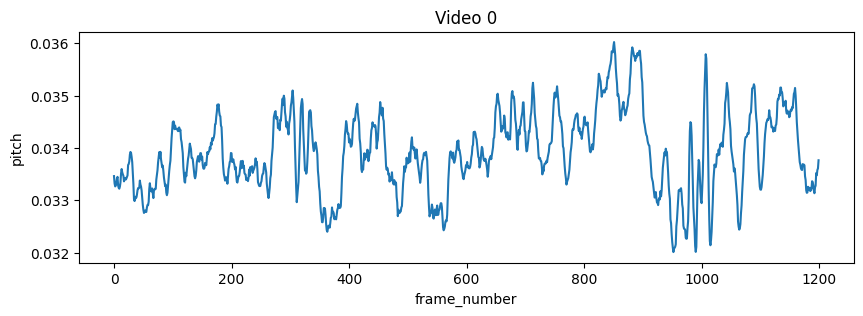

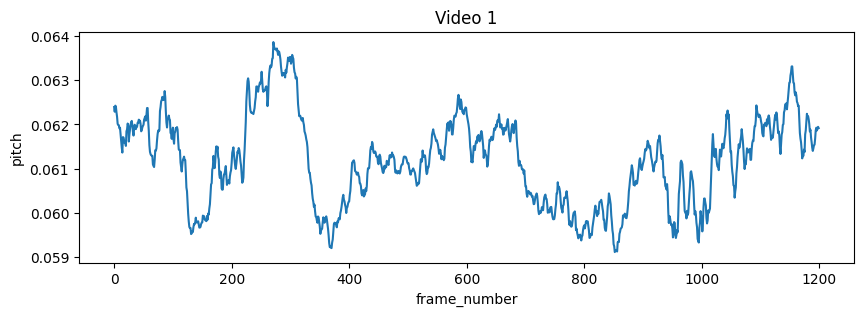

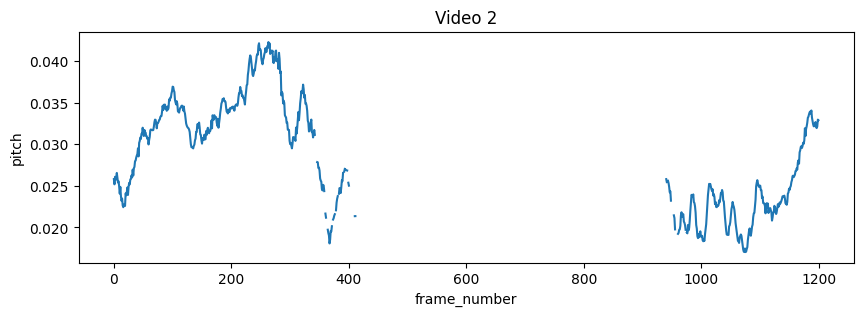

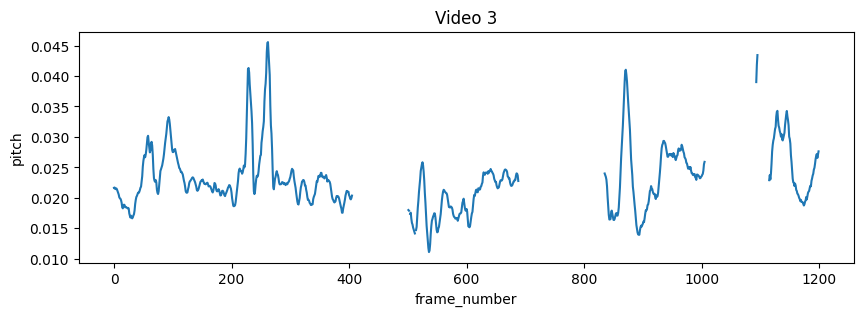

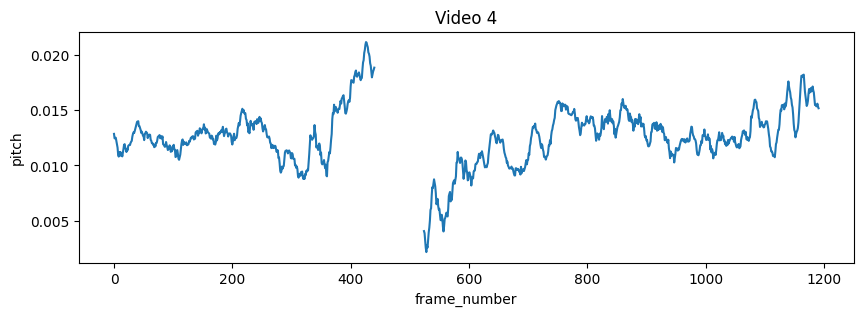

In [ ]:
#Show pitch of all the videos
for video_number, video_data in frames_df.groupby('video_number'):
    plot_data(video_data.frame_number, video_data['pitch'], f"Video {video_number}", 'frame_number', 'pitch')

In [ ]:
#Determine the overall error score on all videos
def get_mse(gt, test):
    test = np.nan_to_num(test)
    return np.mean(np.nanmean((gt - test)**2, axis=0))

def score(predictions, video_number):
    #Use trained CNN model to make new predictions on the labeled data

    zero_mses = []
    mses = []

    for i in range(video_number,video_number+1):
        gt = np.loadtxt('./labeled/' + str(i) + '.txt')
        mask = ~np.isnan(gt).any(axis=1)
        gt = gt[mask]
        zero_mses.append(get_mse(gt, np.zeros_like(gt)))

        test = predictions[mask]
        mses.append(get_mse(gt, test))

    # print(zero_mses)
    # print(mses)

    percent_err_vs_all_zeros = 100*np.mean(mses)/np.mean(zero_mses)
    print(f'YOUR ERROR SCORE IS {percent_err_vs_all_zeros:.2f}% (lower is better)')
    return percent_err_vs_all_zeros

In [ ]:
    elif method == 'wavelet':
        wavelet = kwargs.get('wavelet', 'db4')
        level = kwargs.get('level', 5)
        threshold = kwargs.get('threshold', 0.3)
        def wavelet_filter(x):
            coeffs = pywt.wavedec(x, wavelet, level=level)
            coeffs[1:] = (pywt.threshold(c, value=threshold, mode='soft') for c in coeffs[1:])
            return pywt.waverec(coeffs, wavelet)
        return np.apply_along_axis(wavelet_filter, axis, data)

    elif method == 'kalman':
        process_variance = kwargs.get('process_variance', 1e-3)
        measurement_variance = kwargs.get('measurement_variance', 1)
        n_samples, n_features = data.shape

        # Ensure initial_state_mean has the correct shape
        initial_state_mean = np.full(n_features, fill_value=data[0])

        # Create Kalman filter model
        kf = KalmanFilter(
            initial_state_mean=initial_state_mean,
            initial_state_covariance=np.eye(n_features),
            observation_covariance=np.eye(n_features) * measurement_variance,
            transition_covariance=np.eye(n_features) * process_variance
        )

        # Apply the filter to the data
        filtered_state_means, _ = kf.filter(data)

        return filtered_state_means

In [14]:
import sys
sys.version

'3.8.10 (default, Nov 22 2023, 10:22:35) \n[GCC 9.4.0]'